# Scope the Project and Gather Data
The goal of this project to create a Extract Transform Load(ETL) data process on the global city climate change dataset from Kaggle. For data process, apache spark hosted in Amazon EMR cluster is used to organize data into STAR schema which consist of fact and dimension tables. 


#### The choice of tools and technologies for the project
    * The reasons Apache Spark is chosen:
        1.Apache spark supports both json/csv/other file formats with large amounts of data
        2.Apache Spark process large amount dataset faster due to its distributed cloud architecture.
        3.Spark provides both dataframe and SQL api to study data
    * The reason Amazon cloud is chosen as host for Apache Spark:
        1.Spark running on Amazon EMR cluster can utilize amazon s3 bucket directly with same credit
        2.Multiple Spark cluster can be created in Amazon cloud with scalabity. 

#### Propose how often the data should be updated and why.
    1. The Global Argiculture data is updated yearly.
    2. The Global Surface Temperature data is updated monthly.

# Describe and Gather Data  

#### I used two dataset in this project. 

1. FAOSTAT provides access to over 3 million time-series and cross sectional data relating to Most crop products under agricultural activity. Production Quantity and Seed is in tonnes and

2. Global Land and Ocean-and-Land Temperatures data. I have chosen GlobalLandTemperaturesByCity.csv which record temperature of all the city around the global. 

Both dataset has year recorded which can be used to connnect both dataset.

I believe there are relation between the climate change and the argiculture production.

##### Resources links:

[global-food-agriculture-statistics-crop](https://www.kaggle.com/unitednations/global-food-agriculture-statistics) 2255349 rows

[city_temperature](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data) 8599212 rows




In [35]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns

## Exact, Explore and Assess the Data

#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.



In [37]:
filepath = "weather/globalSurfaceTemperature/archive/GlobalLandTemperaturesByCity.csv"

filepath2 = "weather/argiculture/archive/fao_data_crops_data.csv"

jsonFilePath = 'weather/argiculture/archive/fao_data_crops_data.json'

In [38]:
df = pd.read_csv(filepath)

df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [7]:
# I convert one of the dataset to json

df2 = pd.read_csv(filepath2) 
df3.to_json(jsonFilePath)


In [19]:
df2 = pd.read_json(jsonFilePath ) 
df2.head()

,country_or_area,element_code,element,year,unit,value,value_footnotes,category
0,Americas +,31,Area Harvested,2007.0,Ha,49404.0,A,agave_fibres_nes
1,Americas +,31,Area Harvested,2006.0,Ha,49404.0,A,agave_fibres_nes
2,Americas +,31,Area Harvested,2005.0,Ha,49404.0,A,agave_fibres_nes
3,Americas +,31,Area Harvested,2004.0,Ha,49113.0,A,agave_fibres_nes
4,Americas +,31,Area Harvested,2003.0,Ha,48559.0,A,agave_fibres_nes


## Cleaning Steps
Document steps necessary to clean the data

## Problem 1
#### there are some missing value for avergaeTemperature and AverageTemperatureUncertainty on certain month of a city of a country, but I will keep the rows

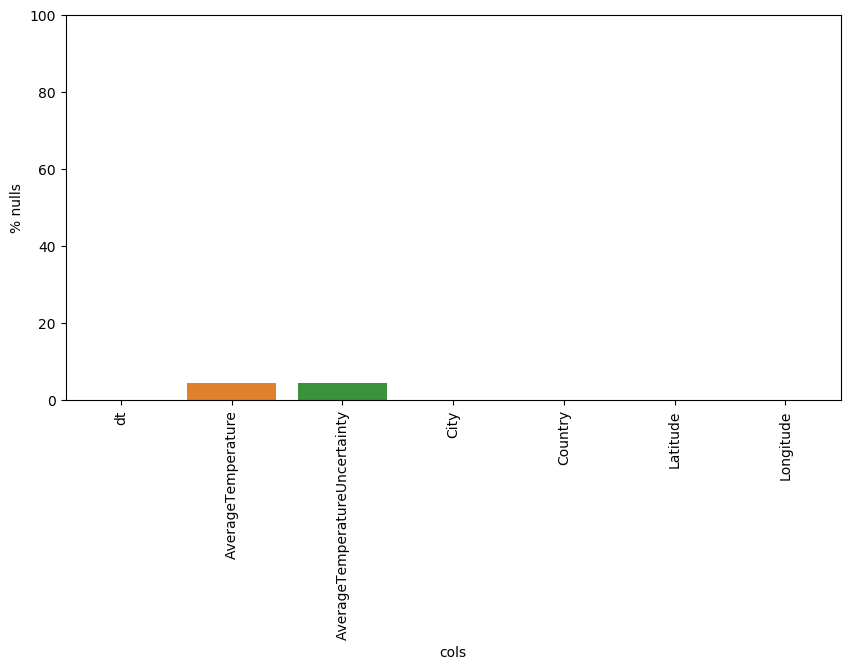

In [39]:
nulls = pd.DataFrame(data= df.isnull().sum(), columns=['values'])
nulls = nulls.reset_index()
nulls.columns = ['cols', 'values']

# percentage of missing values 
nulls['% nulls'] = 100*nulls['values']/df.shape[0]

plt.rcdefaults()
plt.figure(figsize=(10,5))
ax = sns.barplot(x="cols", y="% nulls", data=nulls)
ax.set_ylim(0, 100)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

## Problem 2
#### City temperature contain avg.temperature for each day while GlobalLandTemperaturesByCity has avg.temperature for each month. For this reason, I will calculate the average monthly temperature from City temperature data.
#### Therefore, I will separate dt into year, month, day so that I can use year column to combine both dataset.

## Problem 3
### most value_footnotes has null value and I think it is ok to drop this column

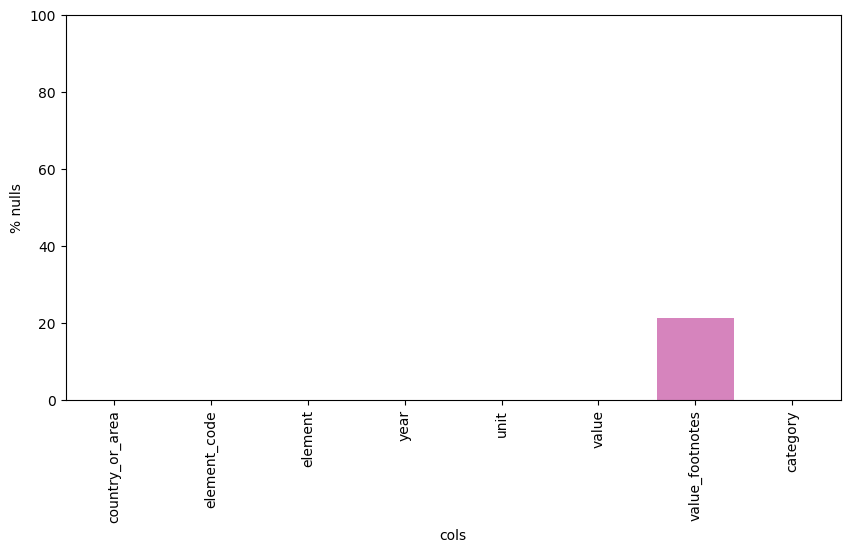

In [26]:
nulls = pd.DataFrame(data= df2.isnull().sum(), columns=['values'])
nulls = nulls.reset_index()
nulls.columns = ['cols', 'values']

# percentage of missing values 
nulls['% nulls'] = 100*nulls['values']/df2.shape[0]

plt.rcdefaults()
plt.figure(figsize=(10,5))
ax = sns.barplot(x="cols", y="% nulls", data=nulls)
ax.set_ylim(0, 100)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

The etl.py script reads data from S3 and creates fact and dimesion tables through Spark that are loaded back into S3.

The goal of this project to create a Extract Transform Load(ETL) data process on the global city climate change dataset from Kaggle. For data process, apache spark hosted in Amazon EMR cluster is used to organize data into STAR schema which consist of fact and dimension tables. 
Dataset links:
https://www.kaggle.com/sudalairajkumar/daily-temperature-of-major-cities
https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data

In [16]:
import os

from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
from pyspark.sql import SQLContext
from pyspark.sql.functions import isnan, when, count, col, udf, dayofmonth, dayofweek, month, year, weekofyear
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.types import *



ModuleNotFoundError: No module named 'pyspark'

In [2]:
spark = SparkSession \
    .builder \
    .appName("Climate Argiculture Spark application") \
    .getOrCreate()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Extract from first csv file

In [3]:
# read climate data file
csvfilepath = "s3a://ykng-bucket/climate_data/GlobalLandTemperaturesByCity.csv"
cf = spark.read.format("csv").option("header","true").load(csvfilepath)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
# print schema and count the number of rows
cf.printSchema()
cf.count()

### Extract data from second set of data

In [4]:
 # read climate data file
#csvfilepath = "s3a://ykng-bucket/climate_data/fao_data_crops_data.csv"
#filepath = "s3a://ykng-bucket/argiculture/Country=United States/*/*.parquet"

jsonfilepath = "s3a://ykng-bucket/climate_data/fao_data_crops_data.csv"
jf = spark.read.json(jsonfilepath)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
# print schema and count the number of rows
jf.printSchema()
jf.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- country_or_area: string (nullable = true)
 |-- element_code: string (nullable = true)
 |-- element: string (nullable = true)
 |-- year: string (nullable = true)
 |-- unit: string (nullable = true)
 |-- value: string (nullable = true)
 |-- value_footnotes: string (nullable = true)
 |-- category: string (nullable = true)

2255349

In [6]:
# create song_data temp View
cf.createOrReplaceTempView("climate_data")
jf.createOrReplaceTempView("argiculture_data")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

***Data dictionary of climate_data***

| Column      | Description |
| ----------- | ----------- |
| country_or_area     | seven regions are: Asia, Africa, North America, South America, Antarctica, Europe, and Australia.  Country name of a nation       |
| element     |     Area harvested, Production Quantity, or  Yield     |
| year  | indicator of date   1961-2019     |
| unit   | Production Quantity and Seed: tonnes /Hg/Ha    |
| value   | The Amount of production      |
| value_footnotes   | Optional notes of value        |
| category   |   type of the crops     |


***Data dictionary argiculture_data***

| column | Description | 
| ----------- | ----------- |
| dt  | Date in YYYY-MM-DD format | 
|  AverageTemperature  | average land temperature in celsius | 
|  AverageTemperatureUncertainty | confidence interval around the average | 
|  City |  Name of City | 
|  Country  |  Name of Country |  
|  Latitude  |   Latitude is Representation of a City Geopoint | 
|  Longitude |  Longitude is Representation of a City City Longitude Geopoint | 

### Fact table and dimension table 
what is fact column:temperatures, unit,Latitude,Longitude
what is dimension columns:element

* Fact:
1. climate_argiculture

climate_id  	placeid 	AverageTemperature	AverageTemperatureUncertainty 	Latitude	Longitude	element 	code	unit	value	value_footnotes 	category
Year	month	day

* Dimension: 
1. places

City	Country 	country_or_area

2. Material:

element_code	element 	category




In [7]:
staging_climate = spark.sql("""SELECT
                               Year(a.dt) as year, month(a.dt) as month, day(a.dt) as day,
                               AverageTemperature,AverageTemperatureUncertainty,
                               City, Country,
                               Latitude, Longitude
                               FROM climate_data a
                            """
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
staging_climate.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+-----+---+-------------------+-----------------------------+-----+-------+--------+---------+
|year|month|day| AverageTemperature|AverageTemperatureUncertainty| City|Country|Latitude|Longitude|
+----+-----+---+-------------------+-----------------------------+-----+-------+--------+---------+
|1743|   11|  1|              6.068|           1.7369999999999999|Århus|Denmark|  57.05N|   10.33E|
|1743|   12|  1|               null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744|    1|  1|               null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744|    2|  1|               null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744|    3|  1|               null|                         null|Århus|Denmark|  57.05N|   10.33E|
|1744|    4|  1| 5.7879999999999985|           3.6239999999999997|Århus|Denmark|  57.05N|   10.33E|
|1744|    5|  1|             10.644|           1.2830000000000001|Århus|Denmark|  57.05N|   10.33E|


In [11]:
staging_climate.createOrReplaceTempView("climate_data2")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
# save the stagin data into s3 bucket
output_path = "s3a://ykng-bucket"
staging_climate.write.partitionBy("Country", "city").parquet(output_path + "/argiculture/", mode="overwrite")

NameError: name 'staging_climate' is not defined

In [9]:
# extract columns to create places table
places_table = spark.sql("""
        SELECT DISTINCT
        md5(a.City || a.Country) place_id, 
        a.City, a.Country
        FROM climate_data a  
        """)
places_table.show()
places_table.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------+-------------+
|            place_id|          City|      Country|
+--------------------+--------------+-------------+
|e12cd41c4115d1a3e...|Puerto Cabello|    Venezuela|
|33e9fdaa53a085263...|       Sanhsia|       Taiwan|
|7c206f635de7fa1fb...|      Satkhira|   Bangladesh|
|c009db860f94559df...|  Staryy Oskol|       Russia|
|6ba089f18a59ad782...|      Voronezh|       Russia|
|6e132203b7ebd7b4f...|        Almere|  Netherlands|
|64eebd3f00c4be86c...|        Ashdod|       Israel|
|afdbaf9562d90e1af...|        Baruta|    Venezuela|
|4d1def5e24d2f355d...|     Concordia|    Argentina|
|be7996cf2ed22b452...|        Geneva|  Switzerland|
|250bec950bd4a8fe1...|    Maastricht|  Netherlands|
|93c9a8db77d2135a2...|       Moundou|         Chad|
|9cca597289ec604e7...|      Osmaniye|       Turkey|
|89ac49c0555965ef3...|         Heihe|       Russia|
|d217ba32747335a24...|       Huadian|        China|
|823adf5fbefb9eab5...| Jinchengjiang|        China|
|021f9d3e4ab

In [ ]:
etl_path = "s3a://ykng-bucket/etl"
#places_tablewrite.parquet(output_path +'/climate_data/', mode="overwrite")
places_table.write.format('json').save(etl_path +'/places.json')

In [16]:
# select columns to fill the  element table

element_table = spark.sql("""
    SELECT DISTINCT
        a.element_code, a.element
        FROM  argiculture_data a
""")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
element_table.show()
element_table.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+
|        element_code|             element|
+--------------------+--------------------+
|Not reported by c...|                null|
|                  41|               Yield|
|                 152|Gross Production ...|
|                 434|Grs per capita PI...|
|                 111|                Seed|
|   Unofficial figure|                null|
|        FAO Estimate|                null|
|                 438|Net per capita PI...|
|                 432|Gross PIN (base 1...|
|                  51| Production Quantity|
|                  31|      Area Harvested|
|                 154|Net Production 19...|
|May include offic...|                null|
|                 436|Net PIN (base 199...|
|            Footnote|                null|
|     Calculated Data|                null|
+--------------------+--------------------+

16

In [ ]:
etl_path = "s3a://ykng-bucket/etl"
#places_tablewrite.parquet(output_path +'/climate_data/', mode="overwrite")
material_table.write.format('json').save(etl_path +'/element.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [13]:
climate_argi_table =  spark.sql("""
        SELECT DISTINCT
        md5(a.City || a.Country) climate_argiculture_id, 
        AverageTemperature, AverageTemperatureUncertainty, 
        Latitude, Longitude, element_code, 
        unit, value, value_footnotes, category,
        a.year, a.month , a.day
        FROM climate_data2 a  
        LEFT JOIN argiculture_data b
        ON a.year = b.year
        AND a.Country = b.country_or_area
        """)



NameError: name 'spark' is not defined

In [ ]:
# show schema and count the rows

climate_argi_table.show()
climate_argi_table.count()

In [14]:
# create temp table view for fact_table

climate_argi_table.createOrReplaceTempView("fact_table")


NameError: name 'climate_argi_table' is not defined

In [13]:
top_materials = spark.sql("SELECT DISTINCT element_code FROM fact_table LIMIT 5")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [ ]:
top_materials.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
    
climate_argi_table.createOrReplaceTempView("fact_table")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
top_materials = spark.sql("""
SELECT DISTINCT AverageTemperature,AverageTemperatureUncertainty, value 
FROM fact_table WHERE year = 1995 
""")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'Table or view not found: material_data; line 4 pos 14'
Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/sql/session.py", line 767, in sql
    return DataFrame(self._jsparkSession.sql(sqlQuery), self._wrapped)
  File "/usr/lib/spark/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1257, in __call__
    answer, self.gateway_client, self.target_id, self.name)
  File "/usr/lib/spark/python/lib/pyspark.zip/pyspark/sql/utils.py", line 69, in deco
    raise AnalysisException(s.split(': ', 1)[1], stackTrace)
pyspark.sql.utils.AnalysisException: 'Table or view not found: material_data; line 4 pos 14'



# Complete Project Write Up


#### The choice of tools and technologies for the project
    * The reasons Apache Spark is chosen:
        1.Apache spark supports both json/csv/other file formats with large amounts of data
        2.Apache Spark process large amount dataset faster due to its distributed cloud architecture.
        3.Spark provides both dataframe and SQL api to study data
    * The reason Amazon cloud is chosen as host for Apache Spark:
        1.Spark running on Amazon EMR cluster can utilize amazon s3 bucket directly with same credit
        2.Multiple Spark cluster can be created in Amazon cloud with scalabity. 
            


#### Propose how often the data should be updated and why.
    1. The Global Argiculture data is updated yearly.
    2. The Global Surface Temperature data is updated monthly.

#### Write a description of how you would approach the problem differently under the following scenarios:
* The data was increased by 100x.
    1. Spark is built with scalabilty in mind and it could increase the number of nodes in our cluster in demand.
    2. The data populates a dashboard that must be updated on a daily basis by 7am every day.
    3. Since the project is done in amazon cloud, it utilize the Lamda function service to trigger a spark python process everyday to update the dashboard.


#### The database needed to be accessed by 100+ people.
    1. The dataset can be migrate to Redshift which provides cheap and faster than other data wirehouse due to its abitlity to utilize Amazon EMR, Sagemaker, Athena, and S3.